# Introduction: Modeling

In this notebook, we will use the calculated feature matrices to train and test a machine learning model. Our objective is a model that can predict, on the first of the month, which customers will churn during the next 30 days.

In [1]:
import pandas as pd
import numpy as np

PARTITION_DIR = 's3://customer-churn-spark'

In [2]:
p0_fm = pd.read_csv(f'{PARTITION_DIR}/p0/MS-30_feature_matrix.csv')
p0_fm.head()

,msno,time,city,bd,registered_via,gender,SUM(logs.num_25),SUM(logs.num_50),SUM(logs.num_75),SUM(logs.num_985),...,WEEKEND(LAST(transactions.membership_expire_date)),DAY(LAST(logs.date)),DAY(LAST(transactions.transaction_date)),DAY(LAST(transactions.membership_expire_date)),MONTH(LAST(logs.date)),MONTH(LAST(transactions.transaction_date)),MONTH(LAST(transactions.membership_expire_date)),label,days_to_churn,churn_date
0,+9zx0+mA3IZQLyjmU88qbfqJ0q9okIfYZnDI6FqaN2o=,2015-01-01,1.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,+sZCvwt5NmFw4uE185pBid4cOxtXTHovIyPFqchulQg=,2015-01-01,1.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,...,1.0,NaN,1.0,1.0,NaN,1.0,2.0,0.0,364.0,0
2,+wzmLe86mMBeoIYoPedlt24WVTW6tabsRcaz81ZXBx0=,2015-01-01,1.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,/9+HJnqEryBbuH598zKqa8zb1Eypy927imqI9IWhJTk=,2015-01-01,8.0,29.0,9.0,male,3.0,0.0,0.0,0.0,...,0.0,1.0,NaN,NaN,1.0,NaN,NaN,0.0,457.0,0
4,/BAK3DkUpoUESh4t8qlWs16yop+sG3i3oPYDpv5uGI0=,2015-01-01,13.0,21.0,9.0,male,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


## Function to Retrieve Data

In [3]:
def retrieve_data(partition_num, label_type='MS-30'):
    return pd.read_csv(f'{PARTITION_DIR}/p{partition_num}/{label_type}_feature_matrix.csv', low_memory=False)

The next cell retrieves a number of feature matrices for training and for testing. This is done in parallel using multiprocessing.

In [4]:
import random
random.seed(50)

from multiprocessing import Pool
pool = Pool(6)

# Set number of train and testing feature matrices
fms_to_get = 50

# Choose random sample of partitions
ps = random.sample(list(range(900)), fms_to_get)

# Retrieve feature matrices from S3
fms = []
for i, r in enumerate(pool.imap_unordered(retrieve_data, ps)):
    print(f'{round(100 * (i / fms_to_get), 2)}% complete.', end='\r')
    fms.append(r)
pool.close()
pool.join()

# Join together and drop rows with unknown label
feature_matrix = pd.concat(fms)
feature_matrix = feature_matrix[~feature_matrix['label'].isna()]
feature_matrix.shape

(1267359, 255)

The cell below converts the boolean types to integers for use in a machine learning model. Most of the boolean indicate whether or not all the values for customer were True (`ALL` primitive) or if the date was a weekend (`WEEKEND` primitive).

In [5]:
feature_matrix = feature_matrix.replace({'False': 0, 'True': 1})

In [6]:
feature_matrix_original = feature_matrix.copy()
feature_matrix.drop(columns = [c for c in ['churn', 'days_to_next_churn', 
                                           'churn_date'] if c in feature_matrix],
                    inplace = True)

bool_cols = [c for c in feature_matrix if 'ALL' in c or ('WEEKEND' in c and 'PERCENT_TRUE' not in c)]

for c in bool_cols:
    feature_matrix[c] = feature_matrix[c].astype(float)
feature_matrix.head()

,ALL(logs.WEEKEND(date)),ALL(transactions.WEEKEND(membership_expire_date) WHERE is_auto_renew = 0),ALL(transactions.WEEKEND(membership_expire_date) WHERE is_auto_renew = 1),ALL(transactions.WEEKEND(membership_expire_date) WHERE is_cancel = 0),ALL(transactions.WEEKEND(membership_expire_date) WHERE is_cancel = 1),ALL(transactions.WEEKEND(membership_expire_date)),ALL(transactions.WEEKEND(transaction_date) WHERE is_auto_renew = 0),ALL(transactions.WEEKEND(transaction_date) WHERE is_auto_renew = 1),ALL(transactions.WEEKEND(transaction_date) WHERE is_cancel = 0),ALL(transactions.WEEKEND(transaction_date) WHERE is_cancel = 1),...,WEEKEND(LAST(transactions.transaction_date)),WEEKEND(registration_init_time),bd,city,days_to_churn,gender,label,msno,registered_via,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,0.0,+/bWThdaZ2Ctp+o+3RgB0FydSf01BZm8S4kIxRHiHfg=,7.0,2015-01-01
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,25.0,5.0,NaN,female,0.0,+1x90quayXba6Eab20tEkfrq7qY5Hu0O66mbWrDiN7c=,9.0,2015-01-01
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,39.0,5.0,5.220000e+02,male,0.0,+IDFFUDMEJ2+iI9j8EZGO3FYJEmcZtTFAuV0nt88dRg=,9.0,2015-01-01
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,0.0,+Io80J+hAkqWIBVn1TdiwbernJubUOovaFCB13BQklM=,7.0,2015-01-01
4,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,...,0.0,0.0,45.0,18.0,3.472222e-13,male,1.0,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,9.0,2015-01-01


# Separate into Training and Testing Set

We'll separate into a training and testing set based on the date. We'll use 25% of the data in the testing and 75% in the testing.

In [7]:
feature_matrix['time'] = pd.to_datetime(feature_matrix['time'])
feature_matrix['time'].describe()

count                 1267359
unique                     27
top       2016-11-01 00:00:00
freq                    59039
first     2015-01-01 00:00:00
last      2017-03-01 00:00:00
Name: time, dtype: object

The cell below splits the data based on the time. First we sort by the time and then find the first 75% for training and the latter 25% for testing.

In [8]:
train_fraction = 0.75
test_start = int(len(feature_matrix) * train_fraction)
feature_matrix.sort_values('time', inplace = True)

train = feature_matrix.iloc[:test_start].copy()
test = feature_matrix.iloc[test_start:].copy()

train.sort_values(['time'], inplace = True)
test.sort_values(['time'], inplace = True)
train.shape, test.shape

((950519, 252), (316840, 252))

# Feature Preparation

The next blocks of code get the features ready for machine learning.

First we need to one hot encode the features. After doing this, we align the training and testing dataframes so they have the same columns.

In [9]:
train = pd.get_dummies(train.drop(columns = ['time', 'msno']))
test = pd.get_dummies(test.drop(columns = ['time', 'msno']))

train, test = train.align(test, join = 'inner', axis = 1)
train.shape, test.shape

((950519, 251), (316840, 251))

Now we can extract the labels. There are two different problems: one is a binary classification of whether or not the customer will churn during the month. The other is a regression: how many days are there until the next churn.

In [10]:
y, test_y = np.array(train.pop('label')), np.array(test.pop('label'))

y_reg, test_y_reg = np.array(train.pop('days_to_churn')), np.array(
    test.pop('days_to_churn'))

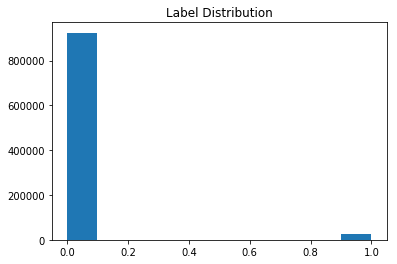

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y); plt.title('Label Distribution');

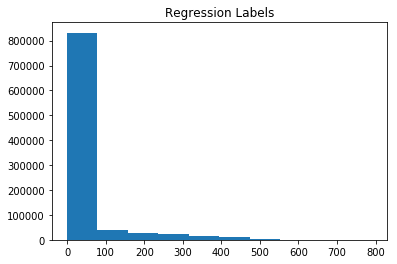

In [12]:
plt.hist(np.nan_to_num(y_reg)); plt.title('Regression Labels');

### Fill in Missing Values

We can fill in missing values using the median of the column. As an important note, the missing test values are filled in with the median of the corresponding training feature.

In [13]:
train = train.replace({np.inf: np.nan, -np.inf: np.nan}).\
    fillna(train.median()).fillna(0)

In [14]:
test = test.replace({np.inf: np.nan, -np.inf: np.nan}).\
    fillna(train.median()).fillna(0)

In [15]:
np.any(train.isnull()), np.any(np.isinf(train))

(False, False)

# Machine Learning

## Baseline Model

We can use a logistic regression in order to see baseline performance on this problem. If the logistic regression works well enough, then there is no need to move to a more complex model.

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs = -1)

In [17]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score


def evaluate(model, train, y, test, test_y):
    model.fit(train, y)

    probs = model.predict_proba(test)[:, 1]
    preds = model.predict(test)

    roc = roc_auc_score(test_y, probs)
    name = repr(model).split('(')[0]
    print(f"{name}\n")
    print(f'ROC AUC: {round(roc, 4)}')

    for metric in [precision_score, recall_score, f1_score]:
        print(f'{metric.__name__}: {round(metric(test_y, preds), 4)}')

    return model, preds


model, preds = evaluate(model, train, y, test, test_y)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression

ROC AUC: 0.5678
precision_score: 0.0115
recall_score: 0.0024
f1_score: 0.0039


The baseline model does not perform any better than guessing based on the ROC AUC. This indicates the problem of separating churn from not-churn is non-linear.

## More Complex Model

For a better machine learning model, we can move to the Random Forest Classifier. From the results of the logistic regression, this looks to be a non-linear problem which means we should use a model capable of learning a non-linear decision boundary.

In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=40,
                               min_samples_leaf = 50,
                               n_jobs=-1, class_weight = 'balanced')
model, preds = evaluate(model, train, y, test, test_y)

RandomForestClassifier

ROC AUC: 0.7112
precision_score: 0.0643
recall_score: 0.3693
f1_score: 0.1095


The random forest performance is much better than just guessing! This should give us confidence that we have solved the machine learning problem. Let's look at the most important features.

In [19]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=train.columns).\
    sort_values('importance', ascending=False)
fi.head()

,importance
TIME_SINCE_LAST(transactions.transaction_date),0.036389
"TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, membership_expire_date)",0.032529
"TOTAL_PREVIOUS_MONTH(transactions.daily_price, membership_expire_date)",0.023464
LAST(transactions.DAY(transaction_date)),0.021776
DAY(LAST(transactions.transaction_date)),0.018943


# Confusion Matrix

A confusion matrix is often a useful way to visualize predictions. This shows the true values along the top row and the predicted values along the bottom row. Looking at the different cells, we can see where the model performed well and where it did not do so well.

In [20]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.style.use('classic')
    plt.figure(figsize = (9, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 22)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 20)
    plt.yticks(tick_marks, classes, size = 20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size = 20)

    plt.ylabel('True label', size = 22)
    plt.xlabel('Predicted label', size = 22)
    plt.tight_layout()

Confusion matrix, without normalization
[[300600  13692]
 [  1607    941]]


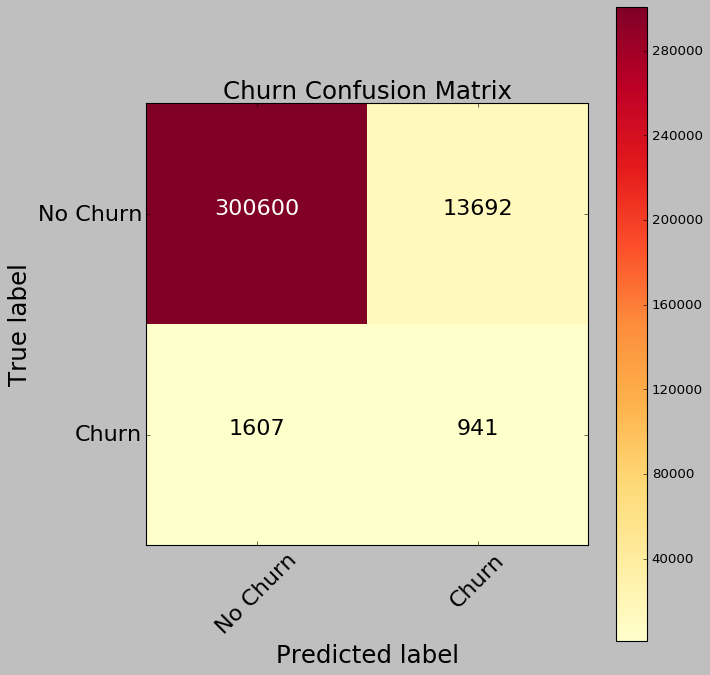

In [21]:
cm = confusion_matrix(test_y, preds)
plot_confusion_matrix(cm, classes = ['No Churn', 'Churn'],
                      title = 'Churn Confusion Matrix')

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature




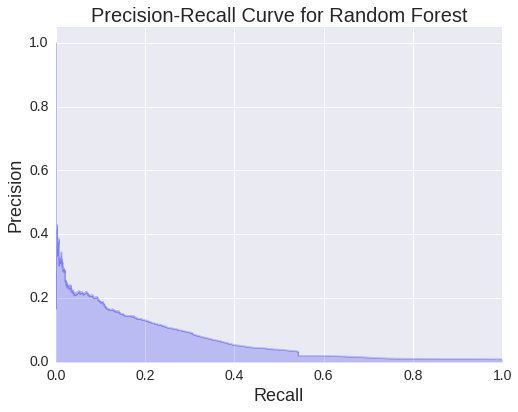

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn');


def plot_precision_recall(test_y, probs, title = 'Precision Recall Curve'):
    precision, recall, threshold = precision_recall_curve(test_y, probs)
    plt.figure(figsize = (8, 6))
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall', size = 18)
    plt.ylabel('Precision', size = 18)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title, size = 20)
    plt.xticks(size = 14); plt.yticks(size = 14)
    
probs = model.predict_proba(test)[:, 1]
plot_precision_recall(test_y, probs, title = 'Precision-Recall Curve for Random Forest')

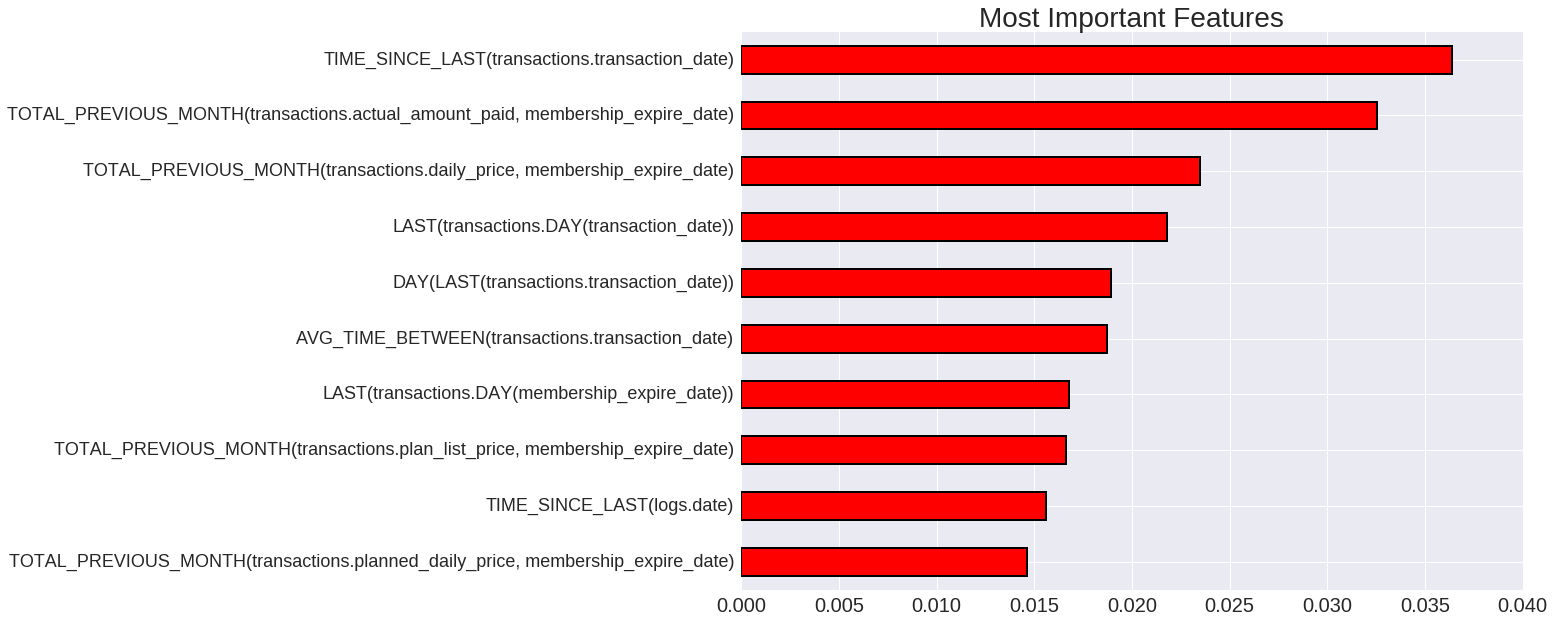

In [24]:
fi.iloc[:10]['importance'].plot.barh(color = 'r', edgecolor = 'k', 
                                     figsize = (14, 10), linewidth = 2)
ax = plt.gca()
ax.invert_yaxis();
plt.xticks(size = 20);
plt.yticks(size = 18)
plt.title('Most Important Features', size = 28);

# Automated Model Optimization Using TPOT

Now we can find the best model automatically using TPOT. This will search through hundreds of machine learning models, using evolutionary algorithms to guide the discovery process.

To find the optimal model, we'll make a `TimeSeriesSplit` object. This will make three splits of the data based on the indexes, so we need to ensure that our data is sorted by time. 

In [25]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 3)

Now we make a `TPOTClassifier` object and pass in a few parameters. This particular use case will search 100 models, using `f1` scoring, the TimeSeriesSplit for cross validation, and taking advantage of all the cores on our machine.

In [26]:
from tpot import TPOTClassifier

tpot_pipeline = TPOTClassifier(generations = 10, population_size = 10, 
                               cv = tss, scoring = 'f1', 
                               n_jobs = 6, verbosity = 2)

In [27]:
train_sample_start = int(0.70 * len(train))
train_sample = train.iloc[train_sample_start:]
y_sample = y[train_sample_start:]

In [ ]:
tpot_pipeline.fit(train_sample, y_sample)

In [ ]:
tpot_pipeline.fitted_pipeline_

In [ ]:
tpot_pipeline.export('best_pipeline.py')

```python
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:0.4381
exported_pipeline = make_pipeline(
    MinMaxScaler(),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=7, max_features=0.75, min_samples_leaf=12, min_samples_split=3, n_estimators=100, subsample=0.05)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)
```

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MinMaxScaler

# # Average CV score on the training set was:0.43811110082970917
# exported_pipeline = make_pipeline(
#     MinMaxScaler(),
#     GradientBoostingClassifier(learning_rate=0.01, max_depth=7, max_features=0.75, 
#                                min_samples_leaf=12, min_samples_split=3, n_estimators=100, subsample=0.05)
# )

In [ ]:
model, preds = evaluate(exported_pipeline, train, y, test, test_y)

In [ ]:
cm = confusion_matrix(test_y, preds)
plot_confusion_matrix(cm, classes = ['No Churn', 'Churn'], title = 'Optimized Model Confusion Matrix')

In [ ]:
probs = model.predict_proba(test)[:, 1]
plot_precision_recall(test_y, probs, title = 'Precision-Recall Curve for Optimized Model')